load all packages

In [3]:
#standard packages
import numpy as np
from numpy import concatenate
import pandas as pd
import glob
import math

from statsmodels.tools.eval_measures import rmse
import warnings

#plot packages
from matplotlib import pyplot
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)

#package to create date-time objects
import datetime as dt

#performance measures
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#LSTM packages
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from tqdm import tqdm
from IPython.utils import io

from scipy.stats import kstest

First we load the dataset, then we transform the date variable to date-time formate and change the column names of the date and target variable to ds and y. Then we drop the AvgSerice variable as we do not which to use this.

In [4]:
df = pd.read_csv(r'C:\Users\Britt\Documents\DataAnalyse\data\half_hour.txt', sep="\t")
df.date = pd.date_range(df.date[0] , periods = len(df.date), freq='30min')
df.rename(columns={'date' : 'ds', 'count' : 'y'}, inplace=True)
df.drop(['AvgService'], axis=1, inplace=True)

We add regressors that represent time such as day of the week which represents what day it is. 0 is monday ...  6 is sunday

In [6]:
df['hour'] = df['ds'].dt.hour
df['weekday'] =df['ds'].dt.weekday
df['month'] = df['ds'].dt.month
df['year'] = df['ds'].dt.year
df.head()

,ds,kperiod,irregular,holiday,y,DeliverD1,DeliverD7,DeliverD14,DeliverD21,Bill1,Bill7,Bill14,Bill21,Deliver,hour,weekday,month,year
0,2004-02-14 00:00:00,1,0,0,55,0,0,0,0,0,0,0,0,0,0,5,2,2004
1,2004-02-14 00:30:00,2,0,0,63,0,0,0,0,0,0,0,0,0,0,5,2,2004
2,2004-02-14 01:00:00,3,0,0,32,0,0,0,0,0,0,0,0,0,1,5,2,2004
3,2004-02-14 01:30:00,4,0,0,38,0,0,0,0,0,0,0,0,0,1,5,2,2004
4,2004-02-14 02:00:00,5,0,0,19,0,0,0,0,0,0,0,0,0,2,5,2,2004


We need the dataframe in the correct format meaning the date needs to be the index. And the varibale that needs to be predicted needs to be in the first colunm. Thus in this case count needs to be moved to the first column.

In [7]:
dfLSTM = df.set_index('ds')
first_column = dfLSTM.pop('y')
dfLSTM.insert(0, 'y', first_column)

Set the size of the training dataset and subsequently the length of the test dataset

In [8]:
len_trainset = round(0.8*len(df))

# Functions for LSTM

series_to_supervised() is a function that puts the dataset into the correct format. It matches the value of count at time t to the values of count at t-1 and the value of the regressors at time t-1. Note here VAR stands for variable and not variance.

In [9]:
# convert series to supervised learning
def series_to_supervised(data, number_of_regressors, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    agg.drop(agg.columns[range(number_of_regressors+1, 2*number_of_regressors)], axis=1, inplace=True)
    return agg

We create a function to forecast. It recursily goes trough the test set and predicts the next value then it add the predcition to the dataset that is used for the next prediciton.

Note: with io.capture_output() as captured: line supresses the output of predict() to make the code more manageble.

In [10]:
def forecast(Train_df, Test_df, look_back, model_LSTM):
    prediction_df = Train_df
    
    for i in  tqdm(range(len(Test_df))):
        x = prediction_df[-look_back:].values
        x = x.reshape((x.shape[0], 1, x.shape[1]))
        with io.capture_output() as captured:
            out = model_LSTM.predict(x)[-1][-1];
        new_row =Test_df.iloc[[i],1:number_of_regressors]
        new_row.insert(0, train_norm.columns[0], out)
        prediction_df = pd.concat([prediction_df, new_row])
    
    return prediction_df

# LSTM

Make the data set normalized

In [21]:
number_of_regressors =  dfLSTM.shape[1]
# load dataset
dataset = dfLSTM
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, number_of_regressors,1, 1)

In [22]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),var16(t-1),var17(t-1),var1(t)
1,0.054509,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.833333,0.0,0.0,0.062438
2,0.062438,0.021277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.833333,0.0,0.0,0.031715
3,0.031715,0.042553,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.833333,0.0,0.0,0.037661
4,0.037661,0.063830,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,0.833333,0.0,0.0,0.018831
5,0.018831,0.085106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.086957,0.833333,0.0,0.0,0.019822


Reshape the dataset into the correct formate for the LSTM function

In [23]:
# split into train and test sets
values = reframed.values
n_train_hours = len_trainset
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(12365, 1, 17) (12365,) (3090, 1, 17) (3090,)


create the model

Epoch 1/200
194/194 [==============================] - 2s 3ms/step - loss: 0.1478 - val_loss: 0.0827
Epoch 2/200
194/194 [==============================] - 0s 2ms/step - loss: 0.0544 - val_loss: 0.0332
Epoch 3/200
194/194 [==============================] - 0s 2ms/step - loss: 0.0330 - val_loss: 0.0306
Epoch 4/200
194/194 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0281
Epoch 5/200
194/194 [==============================] - 0s 2ms/step - loss: 0.0323 - val_loss: 0.0290
Epoch 6/200
194/194 [==============================] - 0s 2ms/step - loss: 0.0306 - val_loss: 0.0294
Epoch 7/200
194/194 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0266
Epoch 8/200
194/194 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.0265
Epoch 9/200
194/194 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.0257
Epoch 10/200
194/194 [==============================] - 0s 2ms/step - loss: 0.0289 - val_lo

194/194 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0280
Epoch 82/200
194/194 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0266
Epoch 83/200
194/194 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0226
Epoch 84/200
194/194 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0243
Epoch 85/200
194/194 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0258
Epoch 86/200
194/194 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0270
Epoch 87/200
194/194 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0243
Epoch 88/200
194/194 [==============================] - 0s 2ms/step - loss: 0.0237 - val_loss: 0.0258
Epoch 89/200
194/194 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0257
Epoch 90/200
194/194 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 

Epoch 161/200
194/194 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0243
Epoch 162/200
194/194 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0258
Epoch 163/200
194/194 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0247
Epoch 164/200
194/194 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0260
Epoch 165/200
194/194 [==============================] - 0s 2ms/step - loss: 0.0222 - val_loss: 0.0241
Epoch 166/200
194/194 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0249
Epoch 167/200
194/194 [==============================] - 0s 2ms/step - loss: 0.0223 - val_loss: 0.0245
Epoch 168/200
194/194 [==============================] - 0s 2ms/step - loss: 0.0229 - val_loss: 0.0243
Epoch 169/200
194/194 [==============================] - 0s 2ms/step - loss: 0.0224 - val_loss: 0.0251
Epoch 170/200
194/194 [==============================] - 0s 2ms/step - lo

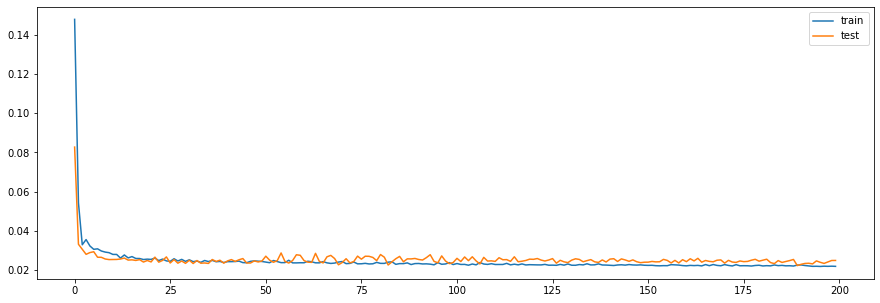

In [24]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), activation='relu'))
model.add(Dense(1, activation='relu'))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y,  epochs=200, batch_size=64, validation_data=(test_X, test_y), verbose=1, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

<h3> Predicting

predict the value of t based on the values 1,..t-1

In [25]:
# make a prediction
yhat_train = model.predict(train_X)
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))

yhat_test = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

yhat_train = concatenate((yhat_train, train_X[:, 1:]), axis=1)
yhat_train_inv = scaler.inverse_transform(yhat_train)[:,0]

yhat_test = concatenate((yhat_test, test_X[:, 1:]), axis=1)
yhat_test_inv = scaler.inverse_transform(yhat_test)[:,0] 

97/97 [==============================] - 0s 996us/step


In [28]:
predictions = np.concatenate((y_pred_train, y_pred_test), axis=0)

In [27]:
y_true_train = df['y'][:len_trainset]
y_true_test = df['y'][len_trainset:]
y_pred_train = yhat_train_inv
y_pred_test = yhat_test_inv

MAEtrain = mean_absolute_error(y_true_train, y_pred_train)
MAEtest = mean_absolute_error(y_true_test[1:], y_pred_test)

print('train MAE', round(MAEtrain, 2))
print('test MAE',  round(MAEtest,2))

train MAE 22.15
test MAE 25.18


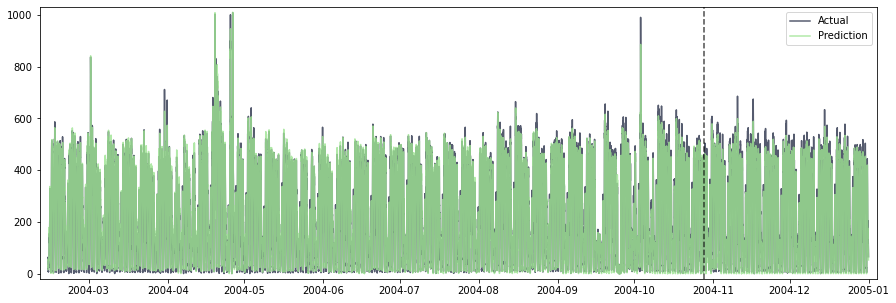

In [30]:
plt.plot(np.asarray(df.ds, dtype='datetime64[s]'), df.y, color= '#555B6E', label = 'Actual')
plt.plot(np.asarray(df.ds, dtype='datetime64[s]')[1:], predictions, color='#9EE493', label = 'Prediction', alpha=0.8)
plt.axvline(x=np.asarray(df.ds, dtype='datetime64[s]')[len_trainset], color='k', linestyle='--', alpha=0.7)
plt.margins(x=0.01)
plt.margins(y=0.02)
plt.legend()

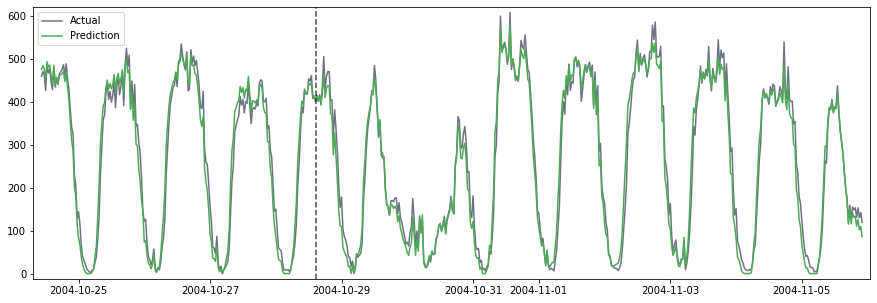

In [31]:
zoom1 = 200 #amount of observation from the train set you see
zoom2 = 400 #amount of observation from test you see

plt.rcParams["figure.figsize"] = (15,5)
fig = plt.figure()

plt.plot(np.asarray(df.ds, dtype='datetime64[s]')[len_trainset-zoom1:len_trainset+zoom2], df.y[len_trainset-zoom1:len_trainset+zoom2], color= '#555B6E', label = 'Actual', alpha=0.85)
plt.plot(np.asarray(df.ds, dtype='datetime64[s]')[len_trainset-zoom1:len_trainset+zoom2], predictions[len_trainset-zoom1:len_trainset+zoom2], color='#4DAA57', label = 'Prediction', alpha=1)
plt.axvline(x=np.asarray(df.ds, dtype='datetime64[s]')[len_trainset], color='k', linestyle='--', alpha=0.7)
plt.legend(loc="upper left")
plt.margins(x=0.01)
plt.margins(y=0.02)

<h3> Forcasting

instead of predciting we recursively predict

In [32]:
len_trainset = round(0.8*len(df))

In [33]:
# split into train and test sets
values = reframed.values
train = values[:len_trainset, :]
test = values[len_trainset:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [34]:
#traindata
Train = dfLSTM.iloc[1:len_trainset+1,:]
#test data
Test = dfLSTM.iloc[len_trainset+1:,:]

In [35]:
test_norm = pd.DataFrame(test_X)
test_norm.columns = Test.columns
test_norm['ds'] = Test.index
test_norm = test_norm.set_index('ds')

train_norm = pd.DataFrame(train_X)
train_norm.columns = Train.columns
train_norm['ds'] = Train.index
train_norm = train_norm.set_index('ds')

In [36]:
forecast_df = forecast(train_norm, test_norm, 1, model)

100%|██████████████████████████████████████████████████████████████████████████████| 3090/3090 [02:45<00:00, 18.67it/s]


In [37]:
inv_yhat = scaler.inverse_transform(forecast_df)
forecast_y = inv_yhat[:,0]

# Results

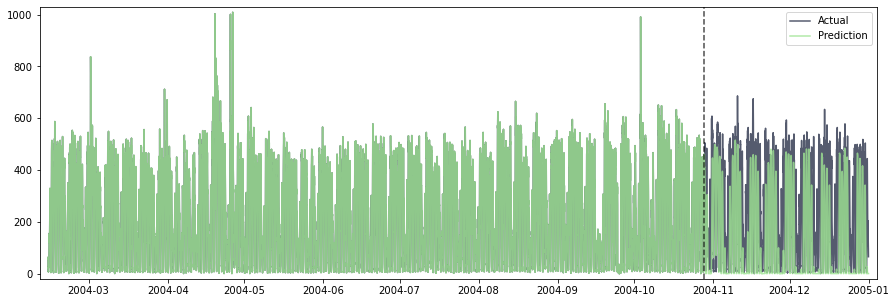

In [38]:
plt.plot(np.asarray(df.ds, dtype='datetime64[s]'), df.y, color= '#555B6E', label = 'Actual')
plt.plot(np.asarray(df.ds, dtype='datetime64[s]')[1:], forecast_y, color='#9EE493', label = 'Prediction', alpha=0.8)
plt.axvline(x=np.asarray(df.ds, dtype='datetime64[s]')[len_trainset], color='k', linestyle='--', alpha=0.7)
plt.margins(x=0.01)
plt.margins(y=0.02)
plt.legend()

zoom in on the test set

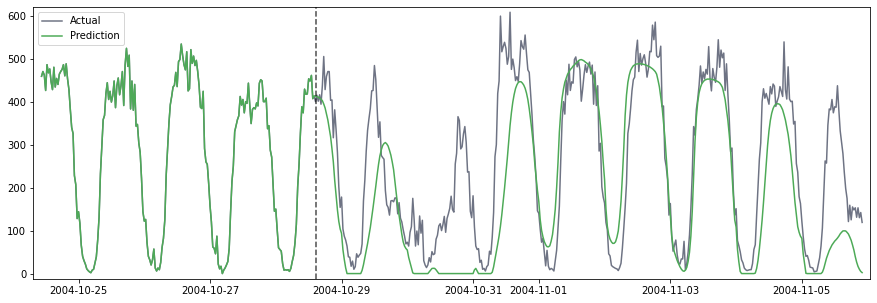

In [39]:
zoom1 = 200 #amount of observation from the train set you see
zoom2 = 400 #amount of observation from test you see

plt.rcParams["figure.figsize"] = (15,5)
fig = plt.figure()

plt.plot(np.asarray(df.ds, dtype='datetime64[s]')[len_trainset-zoom1:len_trainset+zoom2], df.y[len_trainset-zoom1:len_trainset+zoom2], color= '#555B6E', label = 'Actual', alpha=0.85)
plt.plot(np.asarray(df.ds, dtype='datetime64[s]')[len_trainset-zoom1:len_trainset+zoom2], forecast_y[len_trainset-zoom1:len_trainset+zoom2], color='#4DAA57', label = 'Prediction', alpha=1)
plt.axvline(x=np.asarray(df.ds, dtype='datetime64[s]')[len_trainset], color='k', linestyle='--', alpha=0.7)
plt.legend(loc="upper left")
plt.margins(x=0.01)
plt.margins(y=0.02)

# <h2> Multivariate LSTM as Function

Here the above script is turned into a function we you can change the data set and thus the number of regressors and you can change the length of the train set mening you can change the starting point of the forecast.

df_of = dataset with the regressors you want includes.

len_trainset= length trainset

In [ ]:
def LSTM_multivariate(df_og, len_trainset):
    df = df_og.set_index('ds')
    first_column = df.pop('y')
    df.insert(0, 'y', first_column)
    
    number_of_regressors =  df.shape[1]
    # load dataset
    dataset = df
    values = dataset.values
    # integer encode direction
    encoder = LabelEncoder()
    values[:,1] = encoder.fit_transform(values[:,1])
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    # frame as supervised learning
    reframed = series_to_supervised(scaled, 1, 1)
    # drop columns we don't want to predict
    reframed.drop(reframed.columns[range(number_of_regressors+1, 2*number_of_regressors)], axis=1, inplace=True)
    
    # split into train and test sets
    values = reframed.values
    n_train_hours = len_trainset
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    with io.capture_output() as captured:
        history = model.fit(train_X, train_y,  epochs=20, batch_size=20, validation_data=(test_X, test_y), verbose=1, shuffle=False)
    
    #traindata
    Train = df.iloc[1:len_trainset+1,:]
    #test data
    Test = df.iloc[len_trainset+1:,:]
    
    # split into train and test sets
    values = reframed.values
    n_train_hours = len_trainset
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    
    #put normilezed test and train is correct format
    test_norm = pd.DataFrame(test_X)
    test_norm.columns = Test.columns
    test_norm['dsds'] = Test.index
    test_norm = test_norm.set_index('dsds')

    train_norm = pd.DataFrame(train_X)
    train_norm.columns = Train.columns
    train_norm['dsds'] = Train.index
    train_norm = train_norm.set_index('dsds')
    
    forecast_df = forecast(train_norm, test_norm, 15, model)
    
    inv_yhat = scaler.inverse_transform(forecast_df)
    forecast_y = inv_yhat[:,0]
    
    plt.rcParams["figure.figsize"] = (15,5)
    fig = plt.figure()

    plt.plot(df_og['ds'][:-1],df_og['y'][:-1])
    plt.plot(df_og['ds'][:len(forecast_y)],forecast_y)
    plt.axvline(x=pd.to_datetime(df_og.ds.iloc[len_trainset]), color='k', linestyle='--', alpha=0.7)

    plt.show()
    
    zoom1 = 400 #amound of observation from the train set you see
    zoom2 = 500 #amound 

    plt.rcParams["figure.figsize"] = (15,5)
    fig = plt.figure()

    plt.plot(df_og['ds'][len_trainset-zoom1:len_trainset+zoom2],df_og['y'][len_trainset-zoom1:len_trainset+zoom2])
    plt.plot(df_og['ds'][len_trainset-zoom1:len_trainset+zoom2],forecast_y[len_trainset-zoom1:len_trainset+zoom2])
    plt.axvline(x=pd.to_datetime(df_og.ds.iloc[len_trainset]), color='k', linestyle='--', alpha=0.7)
    plt.show()
    
    y_true_test = df['y'][len_trainset:-1]
    y_pred_test = forecast_y[len_trainset:]
    MAEtest = mean_absolute_error(y_true_test, y_pred_test)
    print('test MAE', MAEtest)

100%|██████████████████████████████████████████████████████████████████████████████| 3090/3090 [02:47<00:00, 18.45it/s]


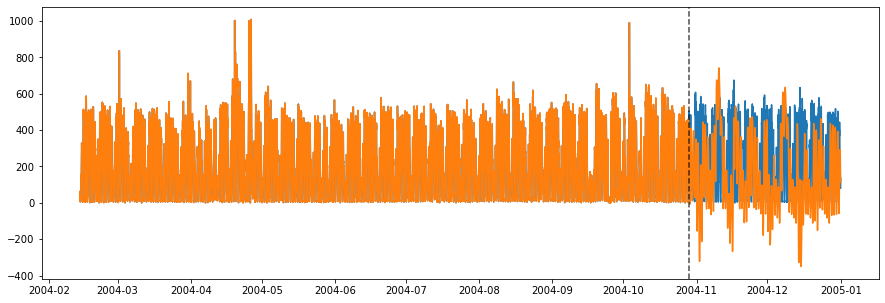

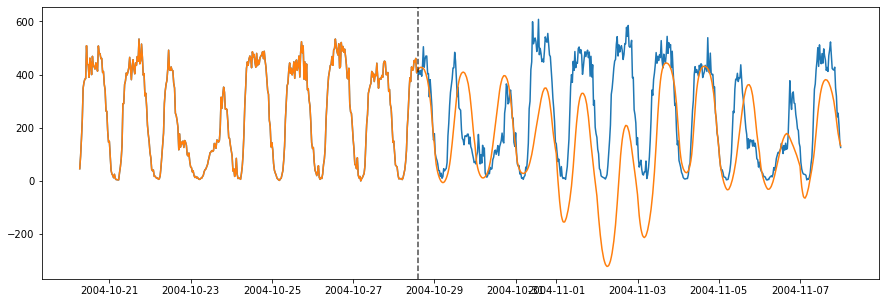

test MAE 153.57599101905683


In [42]:
LSTM_multivariate(df, round(0.8*len(dfLSTM)))

100%|██████████████████████████████████████████████████████████████████████████████| 3086/3086 [02:48<00:00, 18.30it/s]


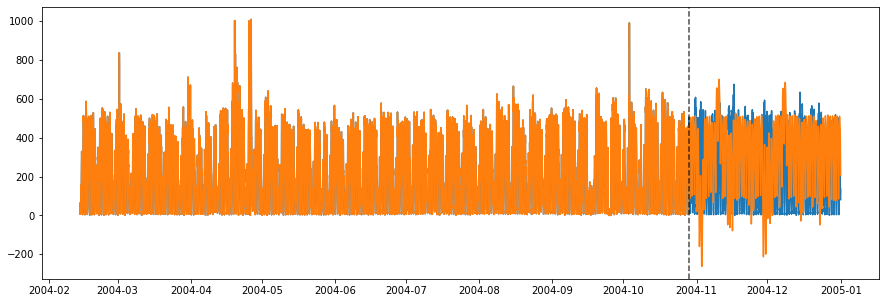

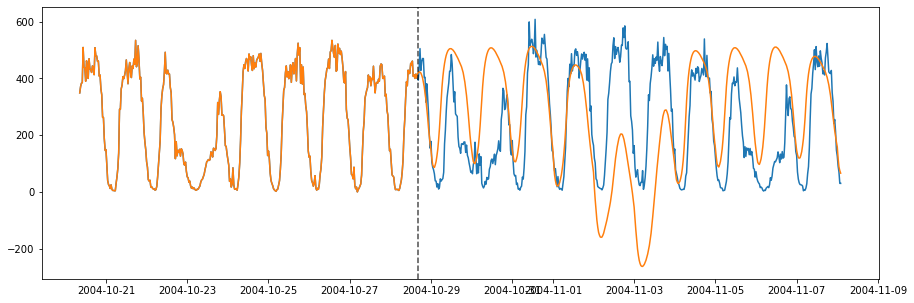

test MAE 141.10115321133617


In [43]:
LSTM_multivariate(df, round(0.8*len(dfLSTM))+4)

100%|██████████████████████████████████████████████████████████████████████████████| 3082/3082 [02:48<00:00, 18.29it/s]


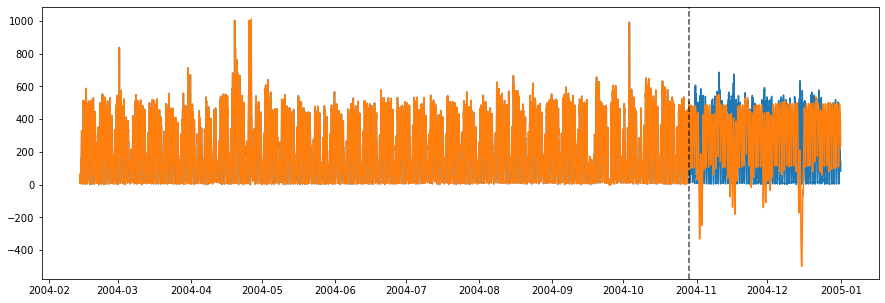

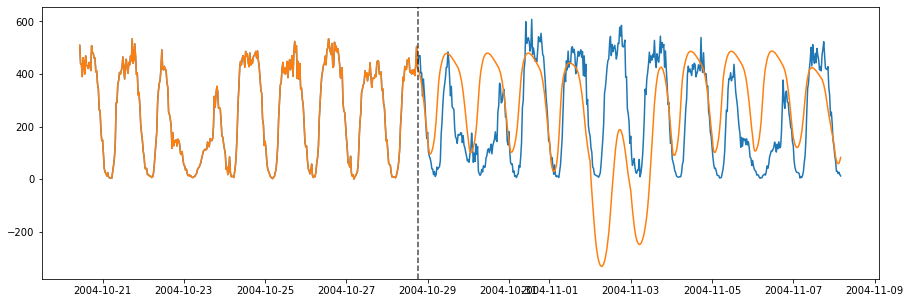

test MAE 146.23527714214606


In [44]:
LSTM_multivariate(df, round(0.8*len(dfLSTM))+8)

In [45]:
LSTM_multivariate(df, round(0.8*len(dfLSTM))+12)

100%|██████████████████████████████████████████████████████████████████████████████| 3078/3078 [02:50<00:00, 18.08it/s]


ValueError: Input contains infinity or a value too large for dtype('float32').